In [1]:
using Pkg
Pkg.add("Plots", io=devnull)
Pkg.add("StatsPlots", io=devnull)
using StatsPlots
using Plots
using Plots.PlotMeasures

In [2]:
struct Result
    net :: String
    spec :: String
    status :: String
    runtime :: Int64
    num_propagation :: Int64
    num_input_splits :: Int64
    num_neuron_splits :: Int64
    initial_δ_bound :: Float64
    final_δ_bound :: Float64
end

struct Results
    verifier_name :: String
    results :: Vector{Result}
end

In [3]:
function read_results(name::String, csv_dir::String; sort_func=nothing)
    results = Result[]
    open(csv_dir, "r") do f
        while !eof(f)
            line = split(replace(readline(f), " " => ""), ",")
            net = line[1]
            spec = line[2]
            status = line[3]
            runtime = parse(Int64, string(line[4]))
            num_propagation = parse(Int64, string(line[5]))
            num_input_splits = parse(Int64, string(line[6]))
            num_neuron_splits = parse(Int64, string(line[7]))
            initial_δ_bound = parse(Float64, string(line[8]))
            final_δ_bound = parse(Float64, string(line[9]))
            push!(results, Result(net, spec, status, runtime, num_propagation, num_input_splits, num_neuron_splits, initial_δ_bound, final_δ_bound))
        end
    end
    if !isnothing(sort_func)
        sort!(results, by=sort_func)
    end
    return Results(name, results)
end

read_results (generic function with 1 method)

In [6]:
cur_dir = @__DIR__
exp_final_dir = joinpath(cur_dir, "experiments_final")

acas_name = "acas-0.5"
mnist_name = "mnist-1.0"

results_name = "results.csv"

verydiff_name = "VeryDiff"
verydiff_acas_path = joinpath(exp_final_dir, verydiff_name, acas_name, results_name)
verydiff_mnist_path = joinpath(exp_final_dir, verydiff_name, mnist_name, results_name)

# heuristic_variants = [["ZB" "ZU" "DB" "DU"], ["Alt" "Base" "Input" "DiffZono" "Input-DiffZono"]]
heuristic_variants = [["DU"], ["Base" "Input-DiffZono"]]

names = ["DeepSplit", "ZonoContract", "ZonoContractInter", "ZonoContractPre", "ZonoContractPost"]
for v in heuristic_variants
    names = reduce(vcat, [d * "-" .* v for d in names])
end

acas_paths = Tuple{String, String}[]
mnist_paths = Tuple{String, String}[]
for name in names
    dir = joinpath(exp_final_dir, name)
    push!(acas_paths, (name, joinpath(dir, acas_name, results_name)))
    push!(mnist_paths, (name, joinpath(dir, mnist_name, results_name)))
end

push!(acas_paths, (verydiff_name, verydiff_acas_path))
push!(mnist_paths, (verydiff_name, verydiff_mnist_path))

println("...")

...


In [5]:
sort_func_solved = r -> r.runtime
sort_func_unsolved = r -> (r.initial_δ_bound - r.final_δ_bound) / (r.initial_δ_bound - 0.5)

acas_results = [read_results(n, p) for (n, p) in acas_paths]
mnist_results = [read_results(n, p) for (n, p) in mnist_paths]

acas_solved, acas_unsolved = Results[], Results[]
mnist_solved, mnist_unsolved = Results[], Results[]

for results in acas_results
    mask = map(r -> r.status != "UNKNOWN", results.results)
    solved = results.results[mask]
    unsolved = results.results[.!mask]
    sort!(solved, by=sort_func_solved)
    sort!(unsolved, by=sort_func_unsolved, rev=true)
    push!(acas_solved, Results(results.verifier_name, solved))
    push!(acas_unsolved, Results(results.verifier_name, unsolved))
end

# for res in acas_unsolved
#     for inst in res.results
#         @assert inst.runtime / 1e9 >= 120.0
#     end
# end

for results in mnist_results
    mask = map(r -> r.status != "UNKNOWN", results.results)
    solved = results.results[mask]
    unsolved = results.results[.!mask]
    sort!(solved, by=sort_func_solved)
    sort!(unsolved, by=sort_func_unsolved, rev=true)
    push!(mnist_solved, Results(results.verifier_name, solved))
    push!(mnist_unsolved, Results(results.verifier_name, unsolved))
end


In [6]:
x_acas_solved = map(r -> 1:size(r.results, 1), acas_solved)
y_acas_solved = map(acas_solved) do r
    return map(r.results) do r
        return r.runtime / 1e9
    end
end

x_mnist_solved = map(r -> 1:size(r.results, 1), mnist_solved)
y_mnist_solved = map(mnist_solved) do r
    return map(r.results) do r
        return r.runtime / 1e9
    end 
end


11-element Vector{Vector{Float64}}:
 [0.001291584, 0.00133827, 0.001374089, 0.001380239, 0.001392876, 0.001425847, 0.011133674, 0.017036737, 0.017434232, 0.01749178  …  0.324773985, 0.508826088, 0.525036607, 1.50568135, 1.69446669, 2.661413681, 6.573588817, 6.844015797, 16.029691523, 84.80142145]
 [0.001248094, 0.001295289, 0.001295649, 0.001318224, 0.001342086, 0.001693005, 0.00960707, 0.017111399, 0.017173364, 0.017180279  …  0.031402864, 0.052075287, 0.39043801, 0.659471885, 0.687838605, 4.495901417, 12.349671975, 17.301815515, 48.803783942, 108.20521043]
 [0.001300273, 0.001384945, 0.001392984, 0.001425217, 0.001586951, 0.005543279, 0.008642526, 0.018376722, 0.018420025, 0.018710958  …  0.094676174, 0.09978119, 0.39001527, 0.667182626, 0.699852468, 4.316783823, 11.623342698, 15.87912951, 35.49417165, 46.191807596]
 [0.00127542, 0.001280167, 0.001329724, 0.001537837, 0.001573023, 0.001642309, 0.010309434, 0.017018192, 0.017038099, 0.017105619  …  0.024560697, 0.030491995, 0.06406509

In [ ]:
verydiff_rgx = r"VeryDiff"
deepsplit_rgx = r"DeepSplit"
zonocontract_rgx = r"ZonoContract-(ZB|ZU|DB|DU)"
zonocontract_pre_rgx = r"ZonoContractPre"
zonocontract_post_rgx = r"ZonoContractPost"
zonocontract_inter_rgx = r"ZonoContractInter"
alt_rgx = r"((ZB|ZU|DB|DU)\-Alt$)"
base_rgx = r"((ZB|ZU|DB|DU)\-Base$)"
input_rgx = r"((ZB|ZU|DB|DU)\-Input$)"
diffzono_rgx = r"((ZB|ZU|DB|DU)\-DiffZono$)"
input_diffzono_rgx = r"((ZB|ZU|DB|DU)\-Input\-DiffZono$)"

config_match_rgx = (res, rgx) -> !isnothing(findfirst(rgx, res.verifier_name))
config_match = (res, rgxs) -> all(map(rgx -> config_match_rgx(res, rgx), rgxs))
filter_indices = (res, rgxs) -> filter(i -> config_match(res[i], rgxs), 1:size(res, 1))

#50 (generic function with 1 method)

In [10]:
verydiff_acas_results = acas_results[filter_indices(acas_results, [verydiff_rgx])][1]
verydiff_mnist_results = mnist_results[filter_indices(mnist_results, [verydiff_rgx])][1]

for res in acas_results
    if res.verifier_name == verydiff_acas_results.verifier_name
        continue
    end
    for i in 1:100
        s₁, s₂ = verydiff_acas_results.results[i].status, res.results[i].status
        p₁, p₂ = verydiff_acas_results.results[i].spec, res.results[i].spec
        @assert s₁ == s₂ || s₁ == "UNKNOWN" || s₂ == "UNKNOWN" "(status₁, prop₁): ($s₁, $p₁), (status₂, prop₂): ($s₂, $p₂)"
    end
end

for res in mnist_results
    if res.verifier_name == verydiff_mnist_results.verifier_name
        continue
    end
    for i in 1:160
        s₁, s₂ = verydiff_mnist_results.results[i].status, res.results[i].status
        p₁, p₂ = verydiff_mnist_results.results[i].spec, res.results[i].spec
        @assert s₁ == s₂ || s₁ == "UNKNOWN" || s₂ == "UNKNOWN" "(status₁, prop₁): ($s₁, $p₁), (status₂, prop₂): ($s₂, $p₂)"
    end
end


In [11]:
verydiff_config = ("VeryDiff", [verydiff_rgx])

base_configs = [
    ("LP-Base", [deepsplit_rgx, base_rgx]), 
    ("ZC-Base", [zonocontract_rgx, base_rgx]),
    ("ZC-Pre-Base", [zonocontract_pre_rgx, base_rgx]),
    ("ZC-Post-Base", [zonocontract_post_rgx, base_rgx]),
    ("ZC-Inter-Base", [zonocontract_inter_rgx, base_rgx]),
]

input_diffzono_configs = [
    ("LP-Input-DiffZono", [deepsplit_rgx, input_diffzono_rgx]),
    ("ZC-Input-DiffZono", [zonocontract_rgx, input_diffzono_rgx]),
    ("ZC-Pre-Input-DiffZono", [zonocontract_pre_rgx, input_diffzono_rgx]),
    ("ZC-Post-Input-DiffZono", [zonocontract_post_rgx, input_diffzono_rgx]),
    ("ZC-Inter-Input-DiffZono", [zonocontract_inter_rgx, input_diffzono_rgx]),
]


5-element Vector{Tuple{String, Vector{Regex}}}:
 ("LP-Input-DiffZono", [r"DeepSplit", r"((ZB|ZU|DB|DU)\-Input\-DiffZono$)"])
 ("ZC-Input-DiffZono", [r"ZonoContract-(ZB|ZU|DB|DU)", r"((ZB|ZU|DB|DU)\-Input\-DiffZono$)"])
 ("ZC-Pre-Input-DiffZono", [r"ZonoContractPre", r"((ZB|ZU|DB|DU)\-Input\-DiffZono$)"])
 ("ZC-Post-Input-DiffZono", [r"ZonoContractPost", r"((ZB|ZU|DB|DU)\-Input\-DiffZono$)"])
 ("ZC-Inter-Input-DiffZono", [r"ZonoContractInter", r"((ZB|ZU|DB|DU)\-Input\-DiffZono$)"])

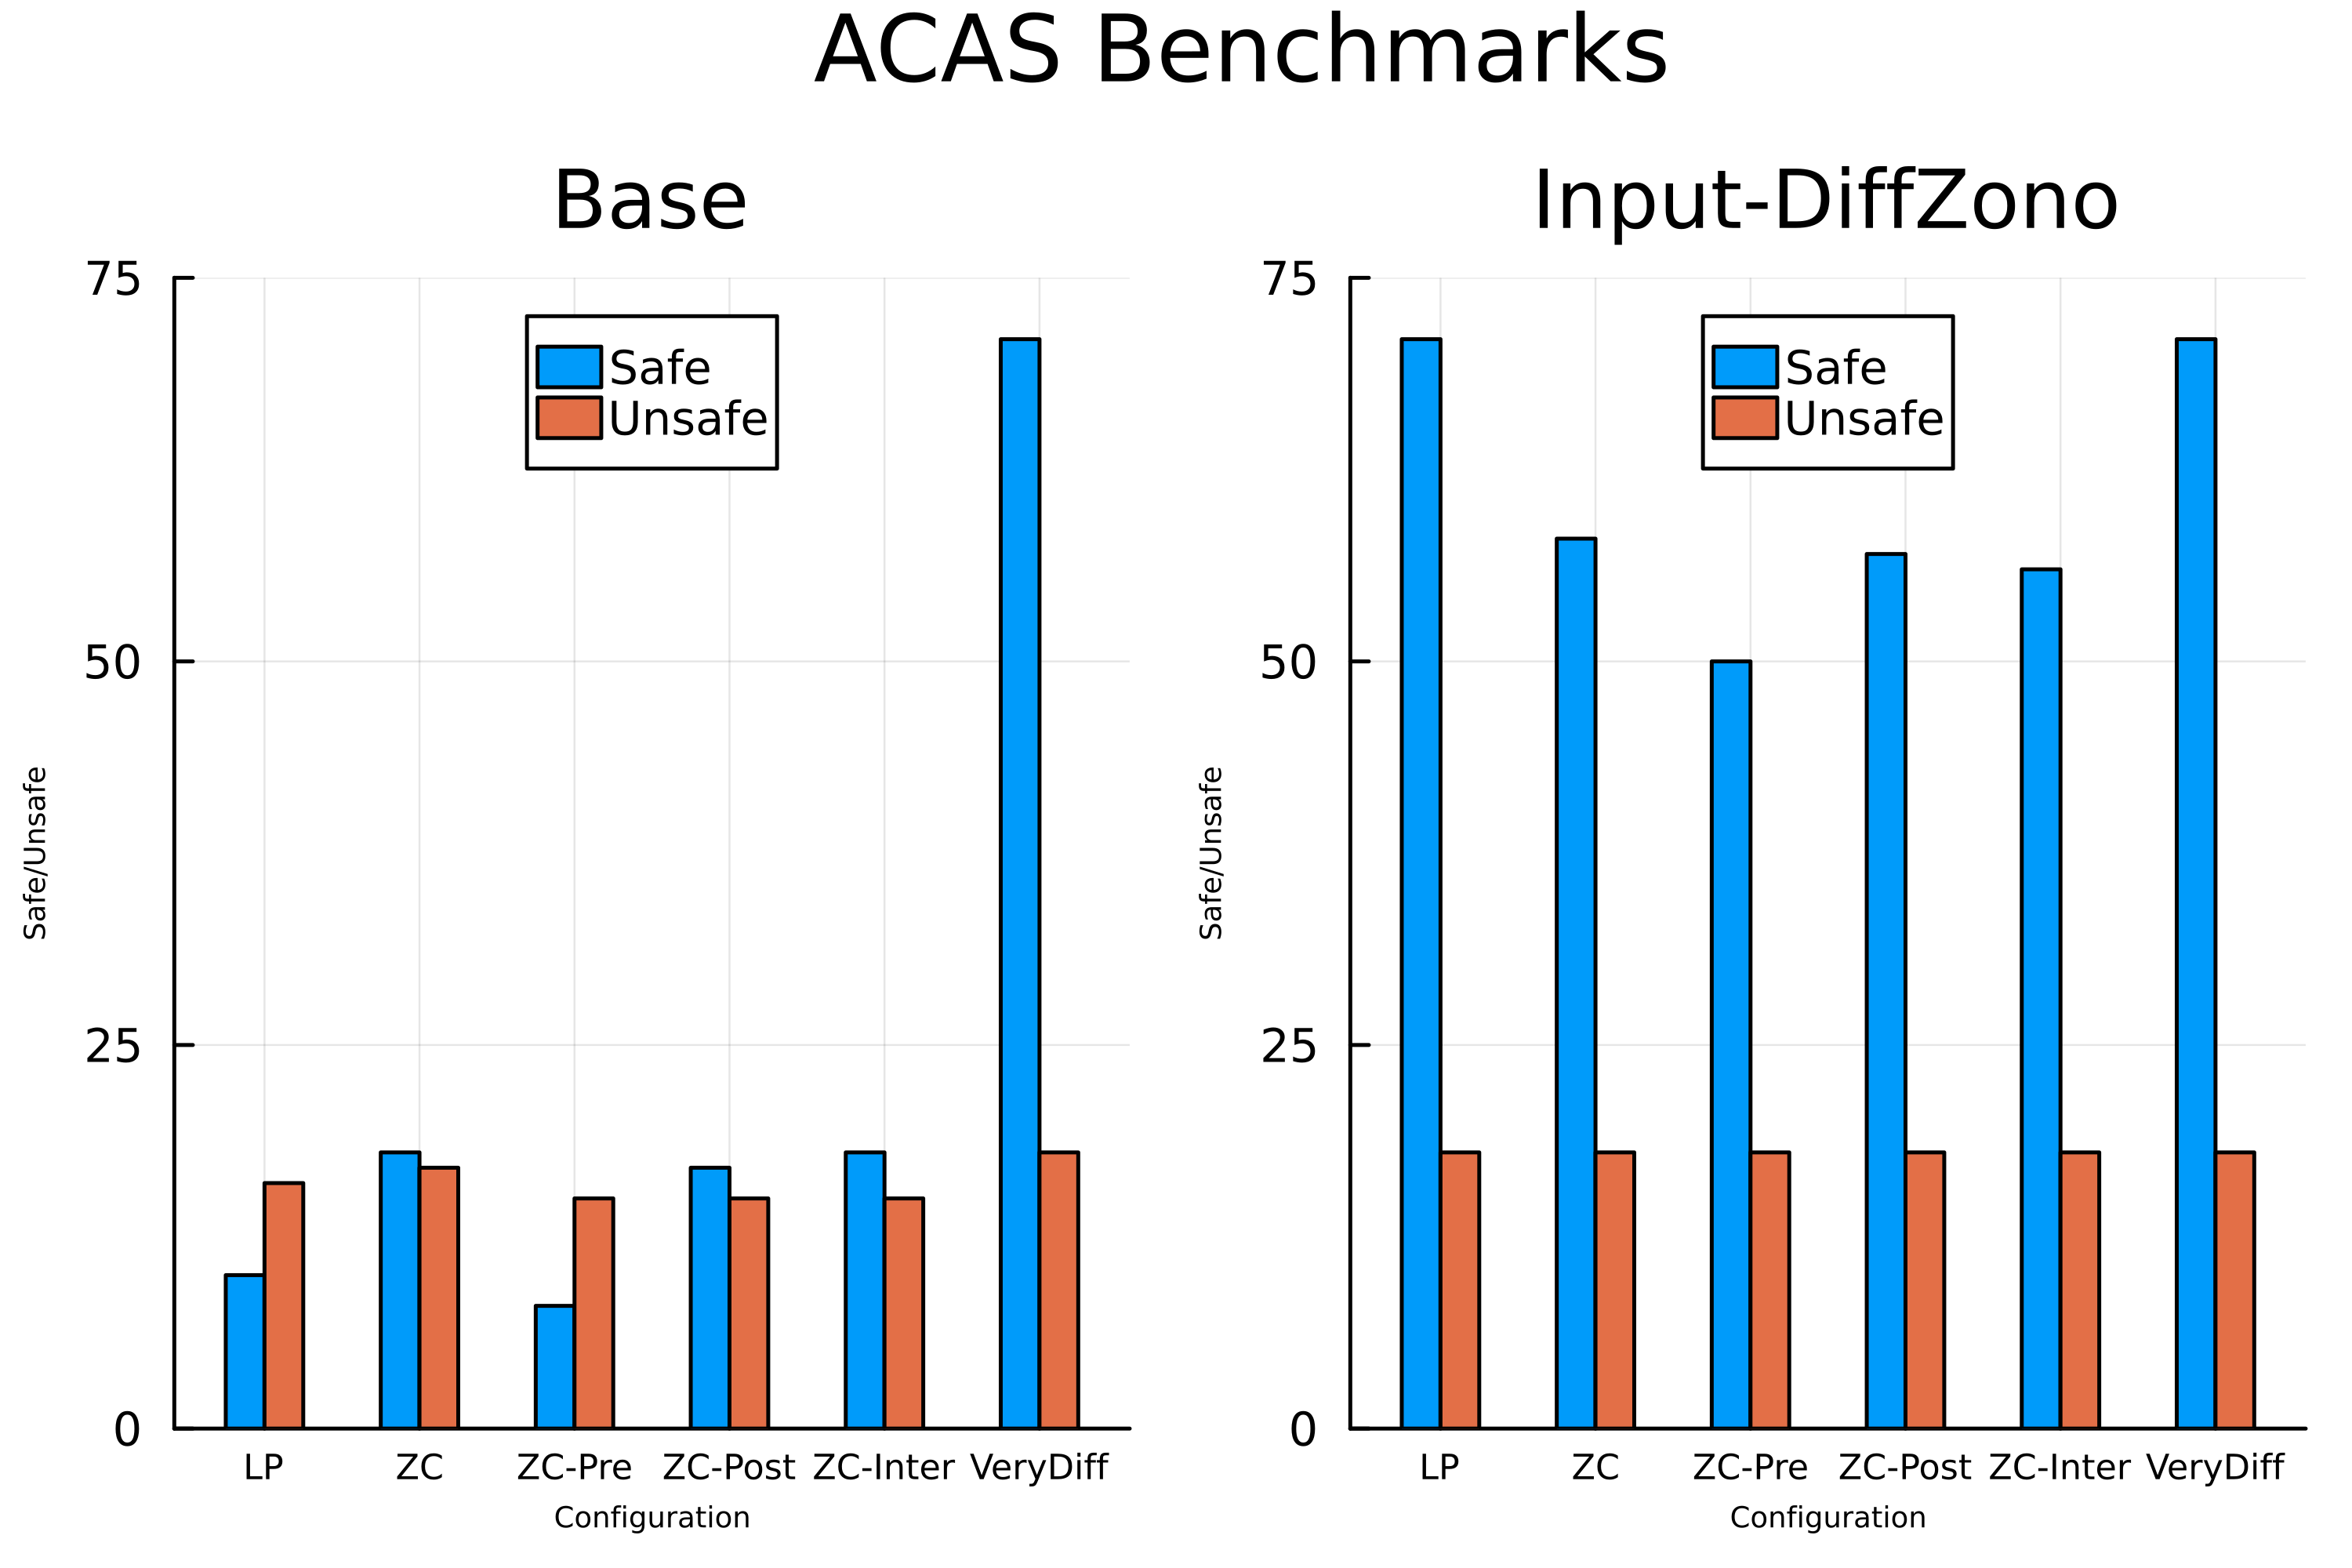

In [128]:
all_configs = [base_configs, input_diffzono_configs]
p = plot(dpi=500, ylims=(0, 75), widen=true, xguidefontsize=5, yguidefontsize=5, xtickfontsize=6, legend=:top, xlabel="Configuration", ylabel="Safe/Unsafe"; layout=2)
# framestyle=:box, c=[:green :red :blue]

titles = ["Base", "Input-DiffZono"]
for (i, configs) in enumerate(all_configs)
    names = String[]
    num_safe, num_unsafe, num_unknown = Int64[], Int64[], Int64[]
    for (name, rgxs) in vcat(configs, verydiff_config)
        indices = filter_indices(acas_results, rgxs)
        push!(num_safe, count(r -> r.status == "SAFE", acas_results[indices][1].results))
        push!(num_unsafe, count(r -> r.status == "UNSAFE", acas_results[indices][1].results))
        # push!(num_unknown, count(r -> r.status == "UNKNOWN", acas_results[indices][1].results))
        push!(names, replace(name, "-$(titles[i])" => ""))
    end
    # groupedbar!(p, names, [num_safe num_unsafe num_unknown], label=["Safe" "Unsafe" "Unknown"], title=titles[i], bar_position=:dodge, lw=1.0, bar_width=0.5, subplot=i)
    groupedbar!(p, names, [num_safe num_unsafe], label=["Safe" "Unsafe"], title=titles[i], bar_position=:dodge, lw=1.0, bar_width=0.5, subplot=i)
end

plot!(p, plot_title="ACAS Benchmarks", plot_titlevspan=0.1)

savefig(p, "acas_benchmarks_hist.png")

p


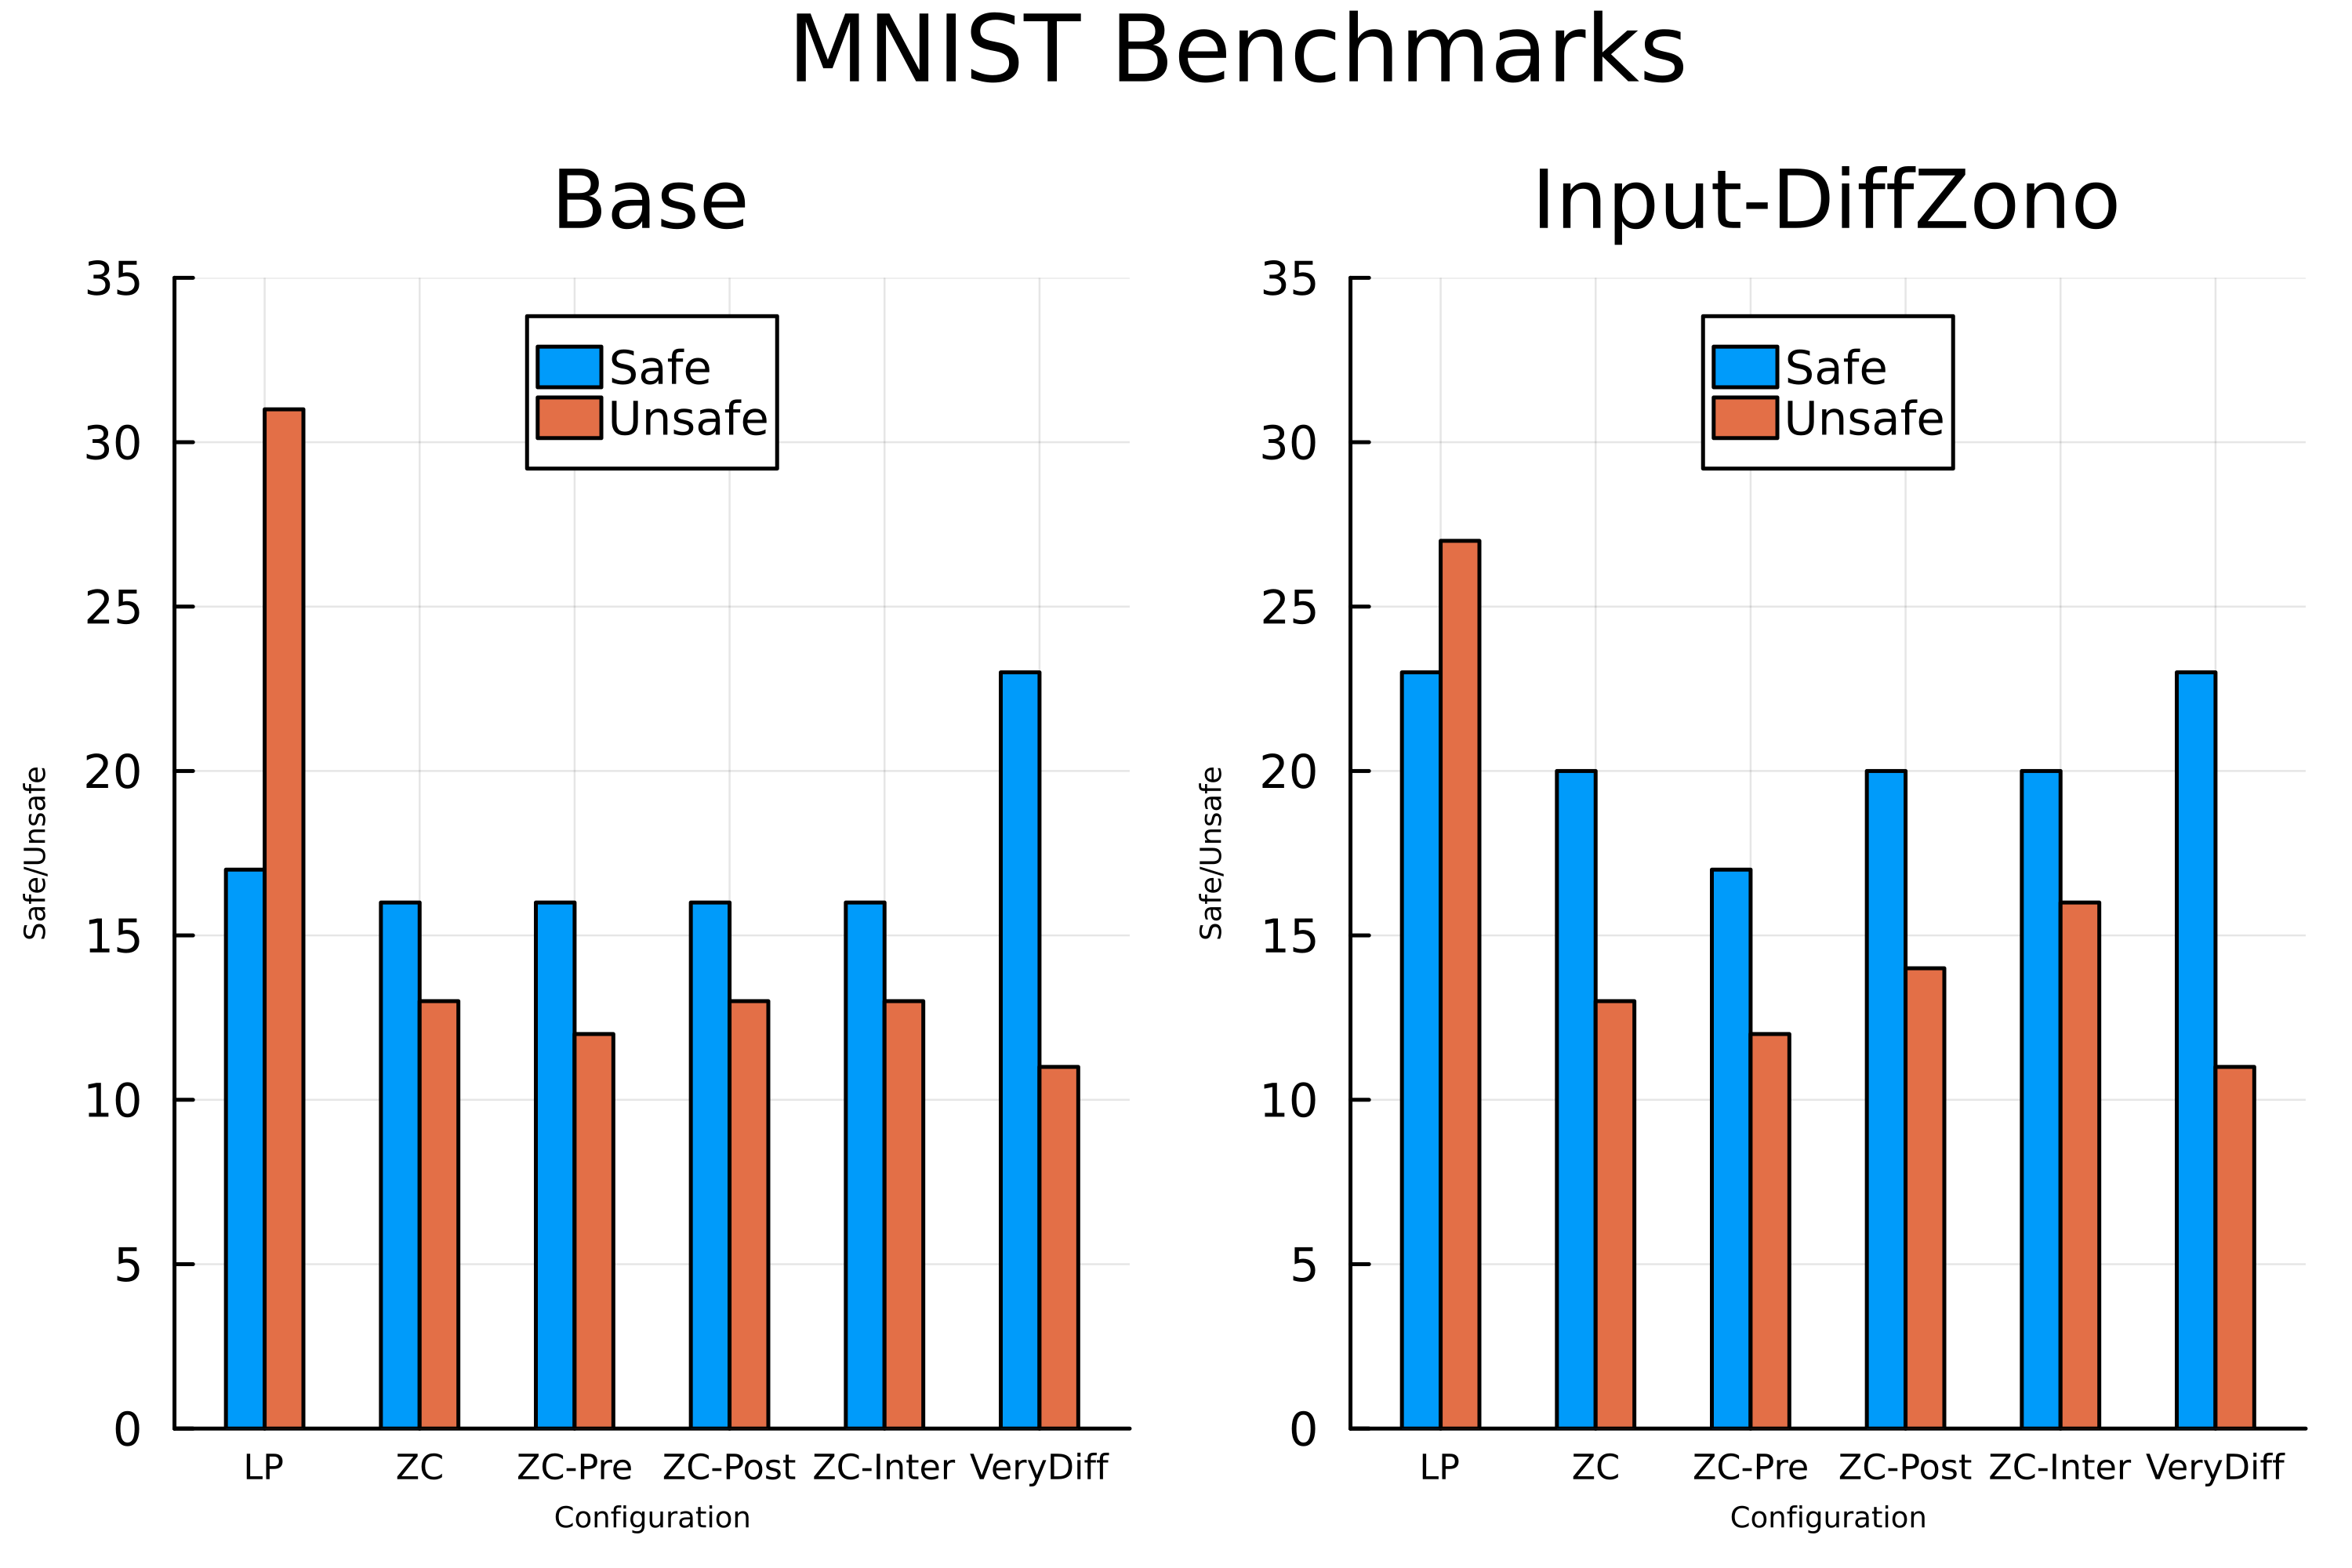

In [125]:
all_configs = [base_configs, input_diffzono_configs]
p = plot(dpi=500, ylims=(0, 35), widen=true, xguidefontsize=5, yguidefontsize=5, xtickfontsize=6, legend=:top, xlabel="Configuration", ylabel="Safe/Unsafe"; layout=2)
# framestyle=:box, c=[:green :red :blue]

titles = ["Base", "Input-DiffZono"]
for (i, configs) in enumerate(all_configs)
    names = String[]
    num_safe, num_unsafe, num_unknown = Int64[], Int64[], Int64[]
    for (name, rgxs) in vcat(configs, verydiff_config)
        indices = filter_indices(mnist_results, rgxs)
        push!(num_safe, count(r -> r.status == "SAFE", mnist_results[indices][1].results))
        push!(num_unsafe, count(r -> r.status == "UNSAFE", mnist_results[indices][1].results))
        # push!(num_unknown, count(r -> r.status == "UNKNOWN", mnist_results[indices][1].results))
        push!(names, replace(name, "-$(titles[i])" => ""))
    end
    # groupedbar!(p, names, [num_safe num_unsafe num_unknown], label=["Safe" "Unsafe" "Unknown"], title=titles[i], bar_position=:dodge, lw=1.0, bar_width=0.5, subplot=i)
    groupedbar!(p, names, [num_safe num_unsafe], label=["Safe" "Unsafe"], title=titles[i], bar_position=:dodge, lw=1.0, bar_width=0.5, subplot=i)
end

plot!(p, plot_title="MNIST Benchmarks", plot_titlevspan=0.1)

savefig(p, "mnist_benchmarks_hist.png")

p


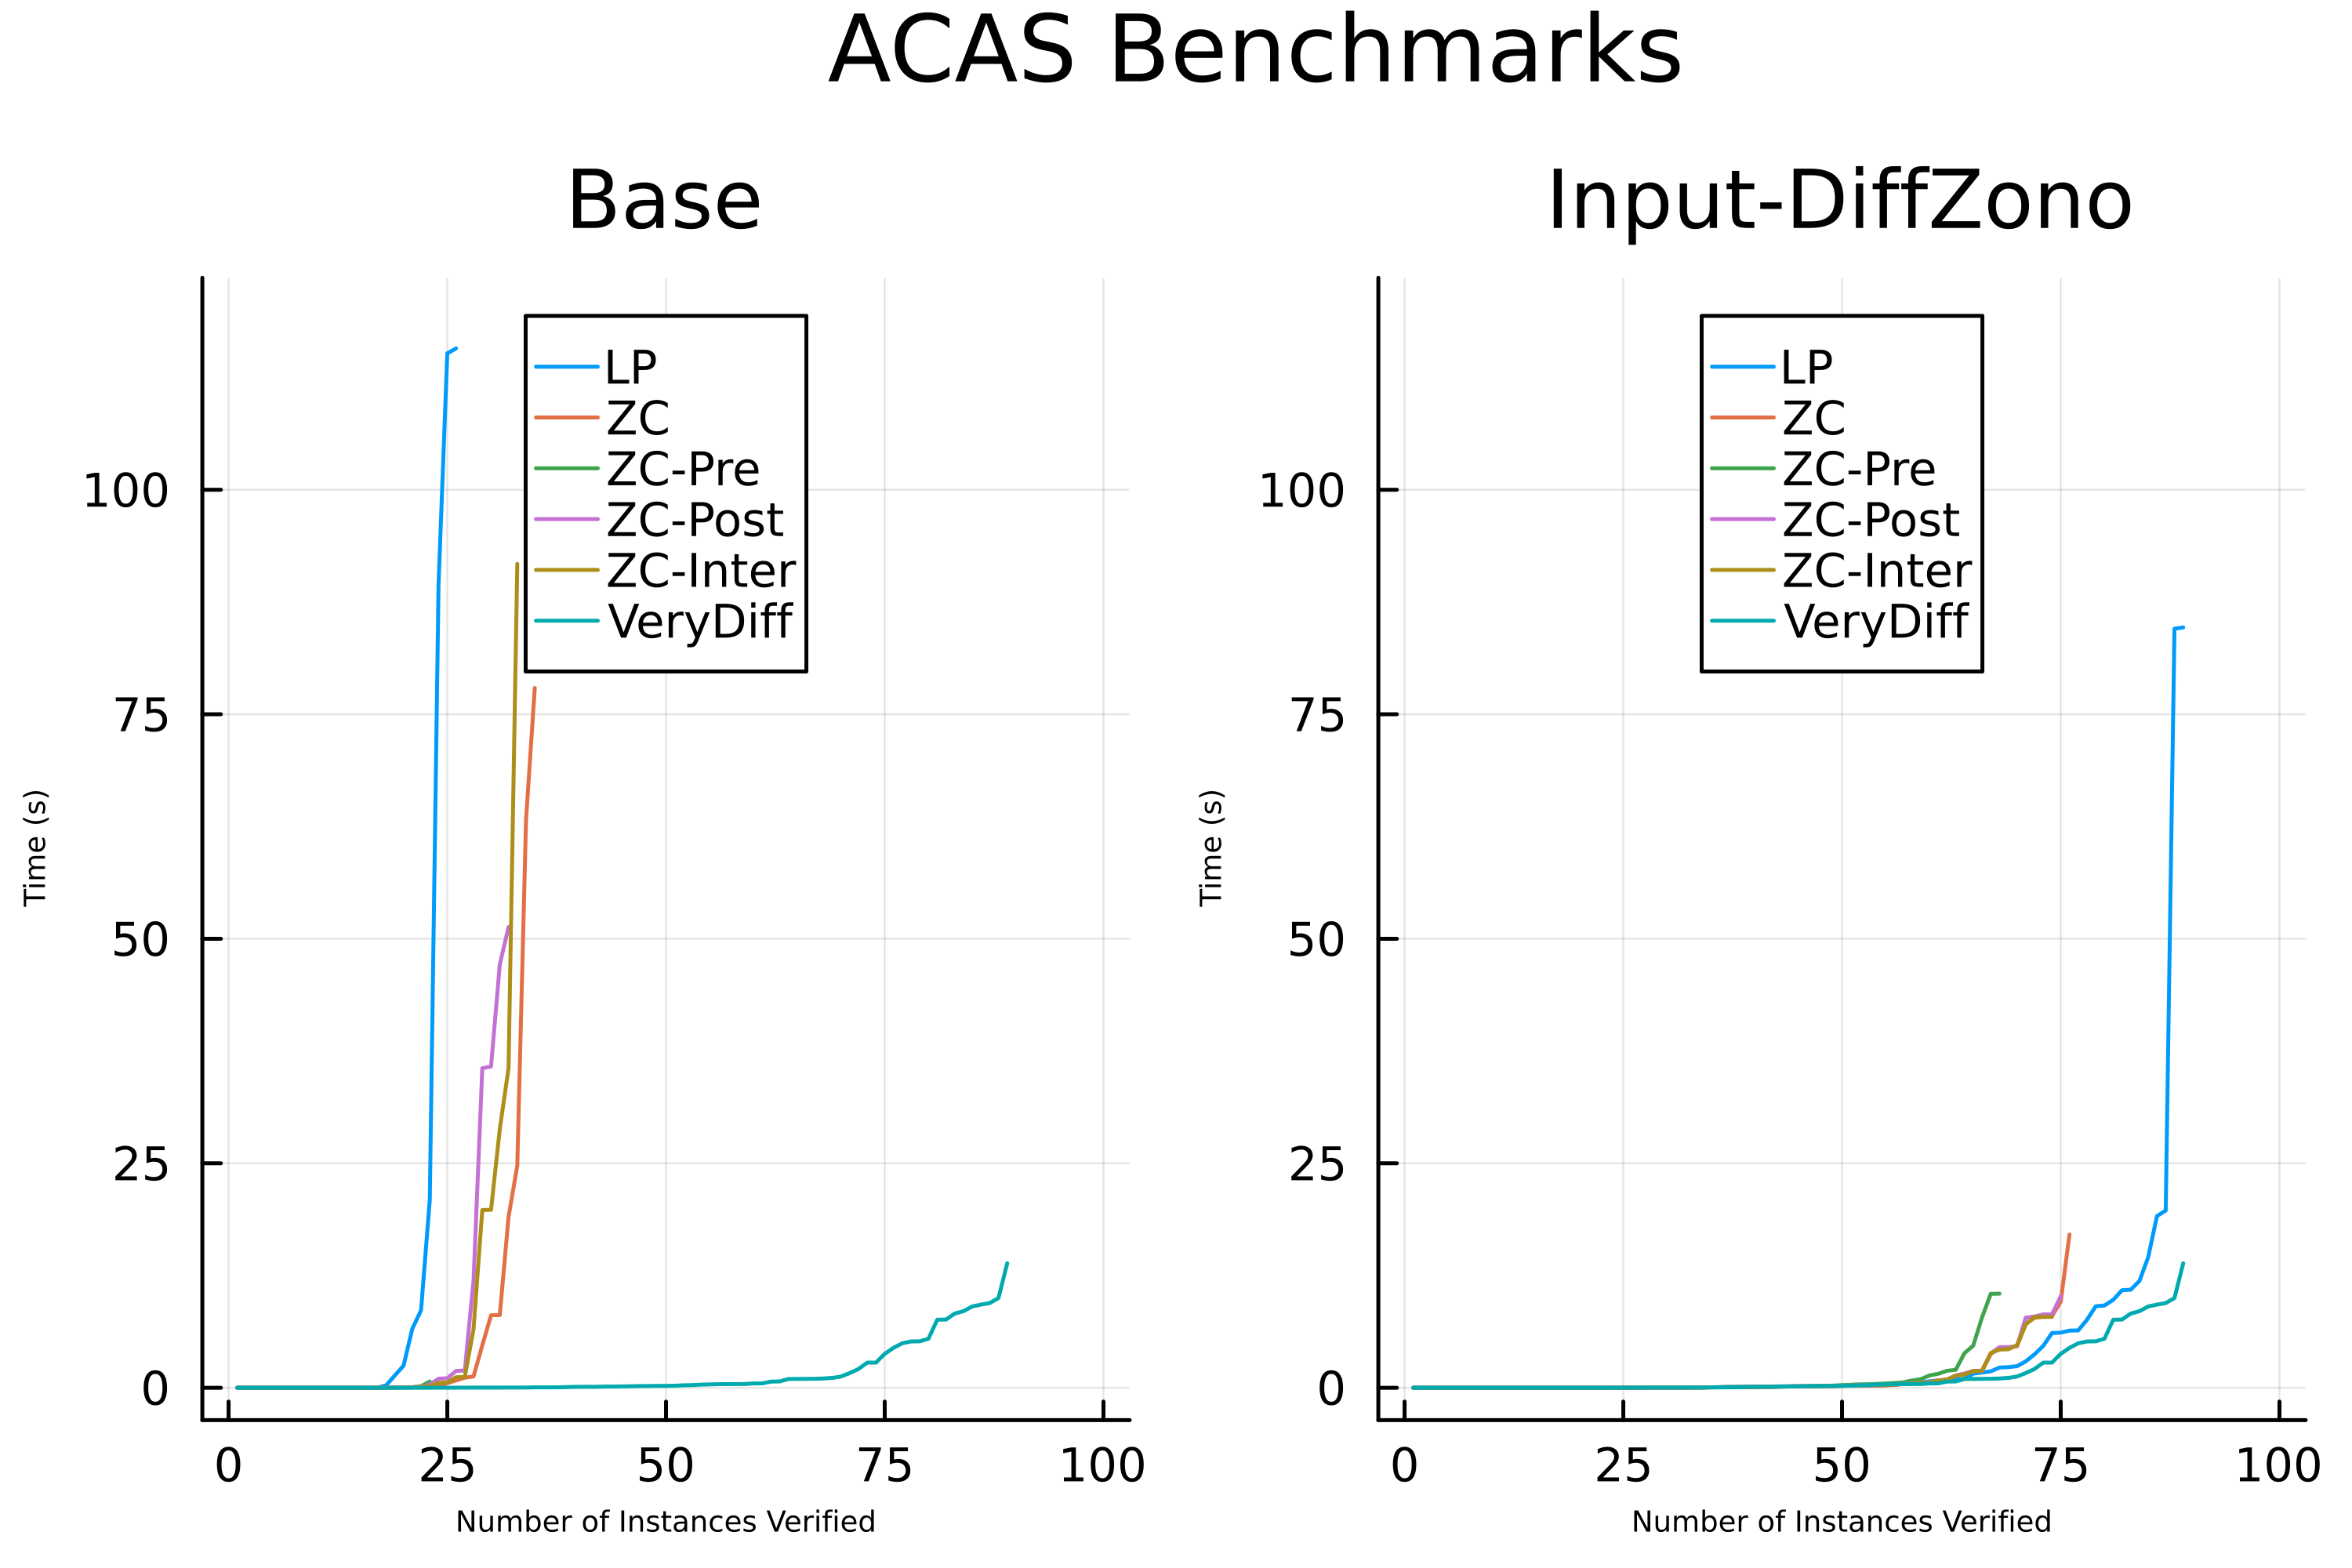

In [15]:
all_configs = [base_configs, input_diffzono_configs]
num_configs = size(all_configs, 1)
p = plot(dpi=500, xlims=(0, 100), ylims=(0, 120), widen=true, xguidefontsize=5, yguidefontsize=5, legend=:top; layout=num_configs)
xlabel!("Number of Instances Verified")
ylabel!("Time (s)")

titles = ["Base", "Input-DiffZono"]
for (i, configs) in enumerate(all_configs)
    for (name, rgxs) in configs
        indices = filter_indices(acas_solved, rgxs)
        plot!(p, x_acas_solved[indices], y_acas_solved[indices], title=titles[i], label=replace(name, "-$(titles[i])" => ""), subplot=i)
    end
    name, rgxs = verydiff_config
    indices = filter_indices(acas_solved, rgxs)
    plot!(p, x_acas_solved[indices], y_acas_solved[indices], label=name, subplot=i)
end

plot!(p, plot_title="ACAS Benchmarks", plot_titlevspan=0.1)

savefig(p, "acas_benchmarks.png")

p

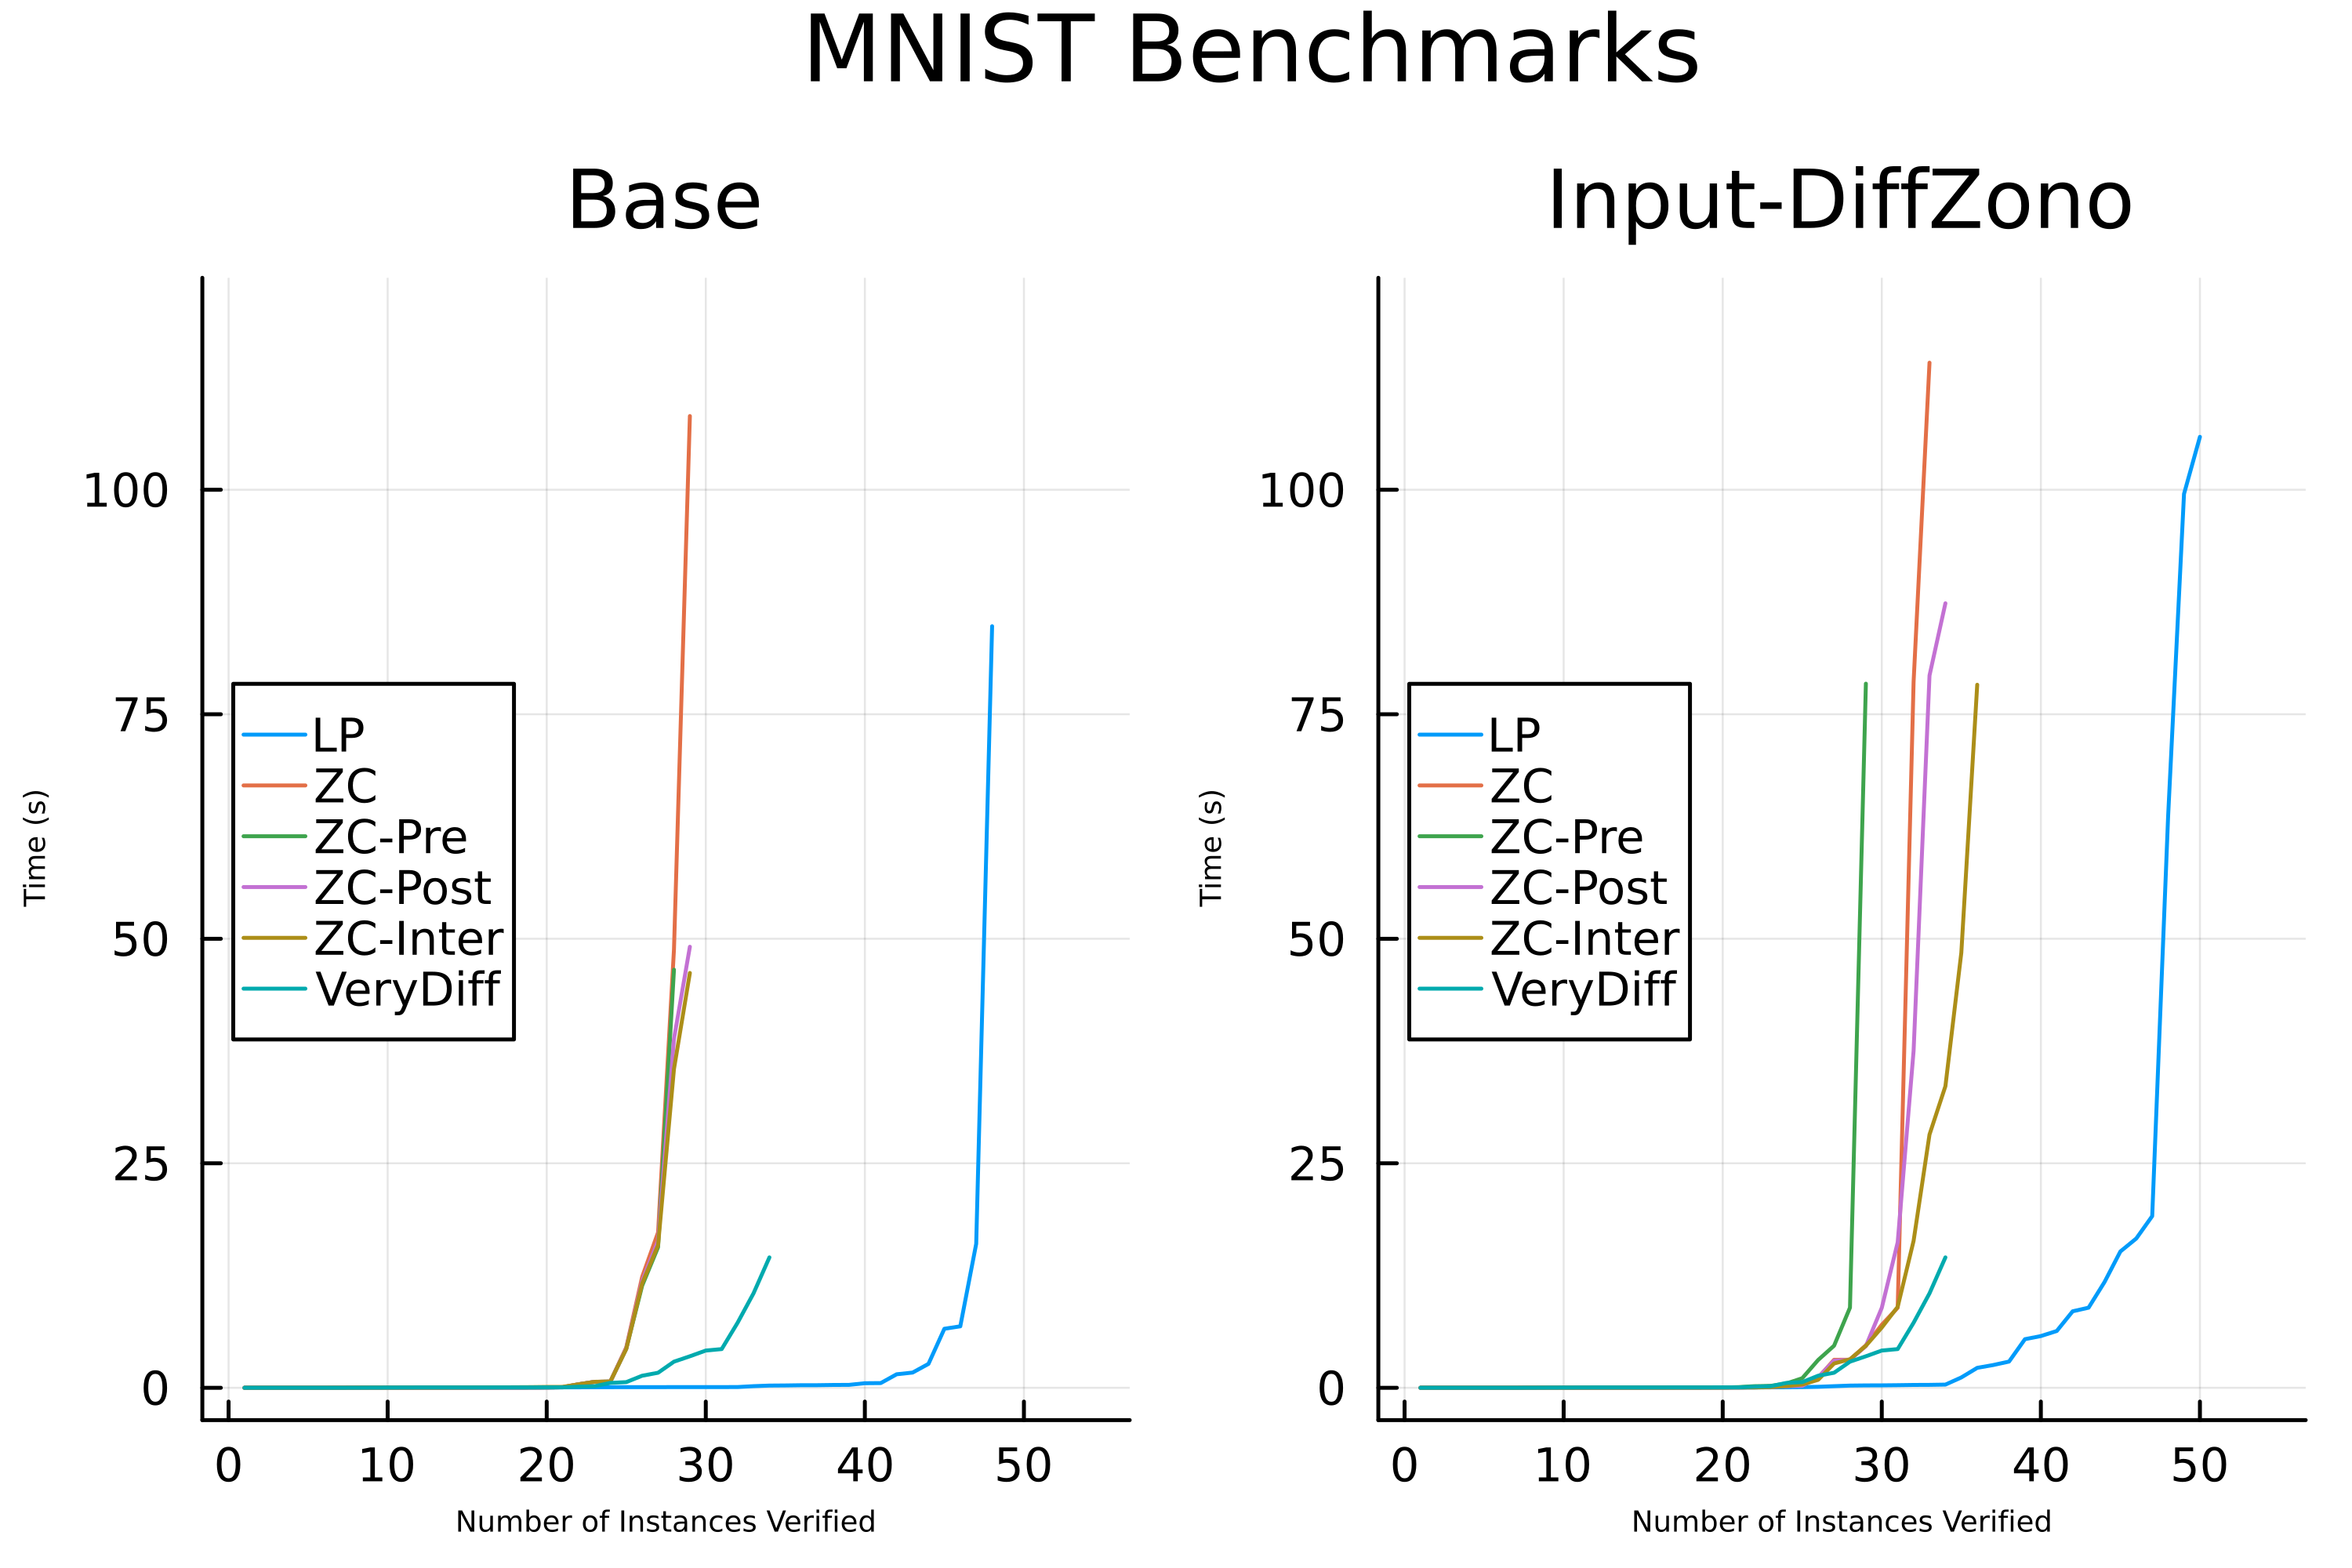

In [16]:
all_configs = [base_configs, input_diffzono_configs]
num_configs = size(all_configs, 1)
p = plot(dpi=500, xlims=(0, 55), ylims=(0, 120), widen=true, xguidefontsize=5, yguidefontsize=5, legend=:left; layout=num_configs)
xlabel!("Number of Instances Verified")
ylabel!("Time (s)")

titles = ["Base", "Input-DiffZono"]
for (i, configs) in enumerate(all_configs)
    for (name, rgxs) in configs
        indices = filter_indices(acas_solved, rgxs)
        plot!(p, x_mnist_solved[indices], y_mnist_solved[indices], title=titles[i], label=replace(name, "-$(titles[i])" => ""), subplot=i)
    end
    name, rgxs = verydiff_config
    indices = filter_indices(acas_solved, rgxs)
    plot!(p, x_mnist_solved[indices], y_mnist_solved[indices], label=name, subplot=i)
end

plot!(p, plot_title="MNIST Benchmarks", plot_titlevspan=0.1)

savefig(p, "mnist_benchmarks.png")

p

In [21]:
x_acas_unsolved = map(r -> 1:size(r.results, 1), acas_unsolved)
y_acas_unsolved = map(acas_unsolved) do r
    return map(r.results) do r
        return (r.initial_δ_bound - r.final_δ_bound) / (r.initial_δ_bound - 0.5)
    end
end

# x_mnist_unsolved = map(r -> 1:size(r.results, 1), mnist_unsolved)
# y_mnist_unsolved = map(mnist_unsolved) do r
#     return map(r.results) do r
        # return (r.initial_δ_bound - r.final_δ_bound) / (r.initial_δ_bound - 0.5)
#     end 
# end

11-element Vector{Vector{Float64}}:
 [0.9463955963545618, 0.908750140183672, 0.8204320351477628, 0.7667272309440252, 0.7179434164476073, 0.6228958620624157, 0.534273201345489, 0.3309082800242404, 0.3018906370206431, 0.1517344097275101  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.9998431911822527, 0.9987024155392032, 0.9983493994614265, 0.9978606297461117, 0.9974043029409778, 0.9974041088678929, 0.9968470197831922, 0.9968461703160151, 0.9965763615470312, 0.9951002393513264  …  0.3522926685883261, 0.33435966996400707, 0.15713411127154353, 0.0644550842860565, 0.02814004150637712, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.9998402707569611, 0.9985471990850339, 0.9981843814665311, 0.9963800363671622, 0.9963793920387891, 0.9962200480422082, 0.996215371149736, 0.9960315071959994, 0.9945884180103217, 0.989885458309016  …  0.1571341112715437, 0.05914566825890215, 0.02814004150637712, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.999756259501887, 0.9982516245827324, 0.9939264349026674, 0.992597052385367

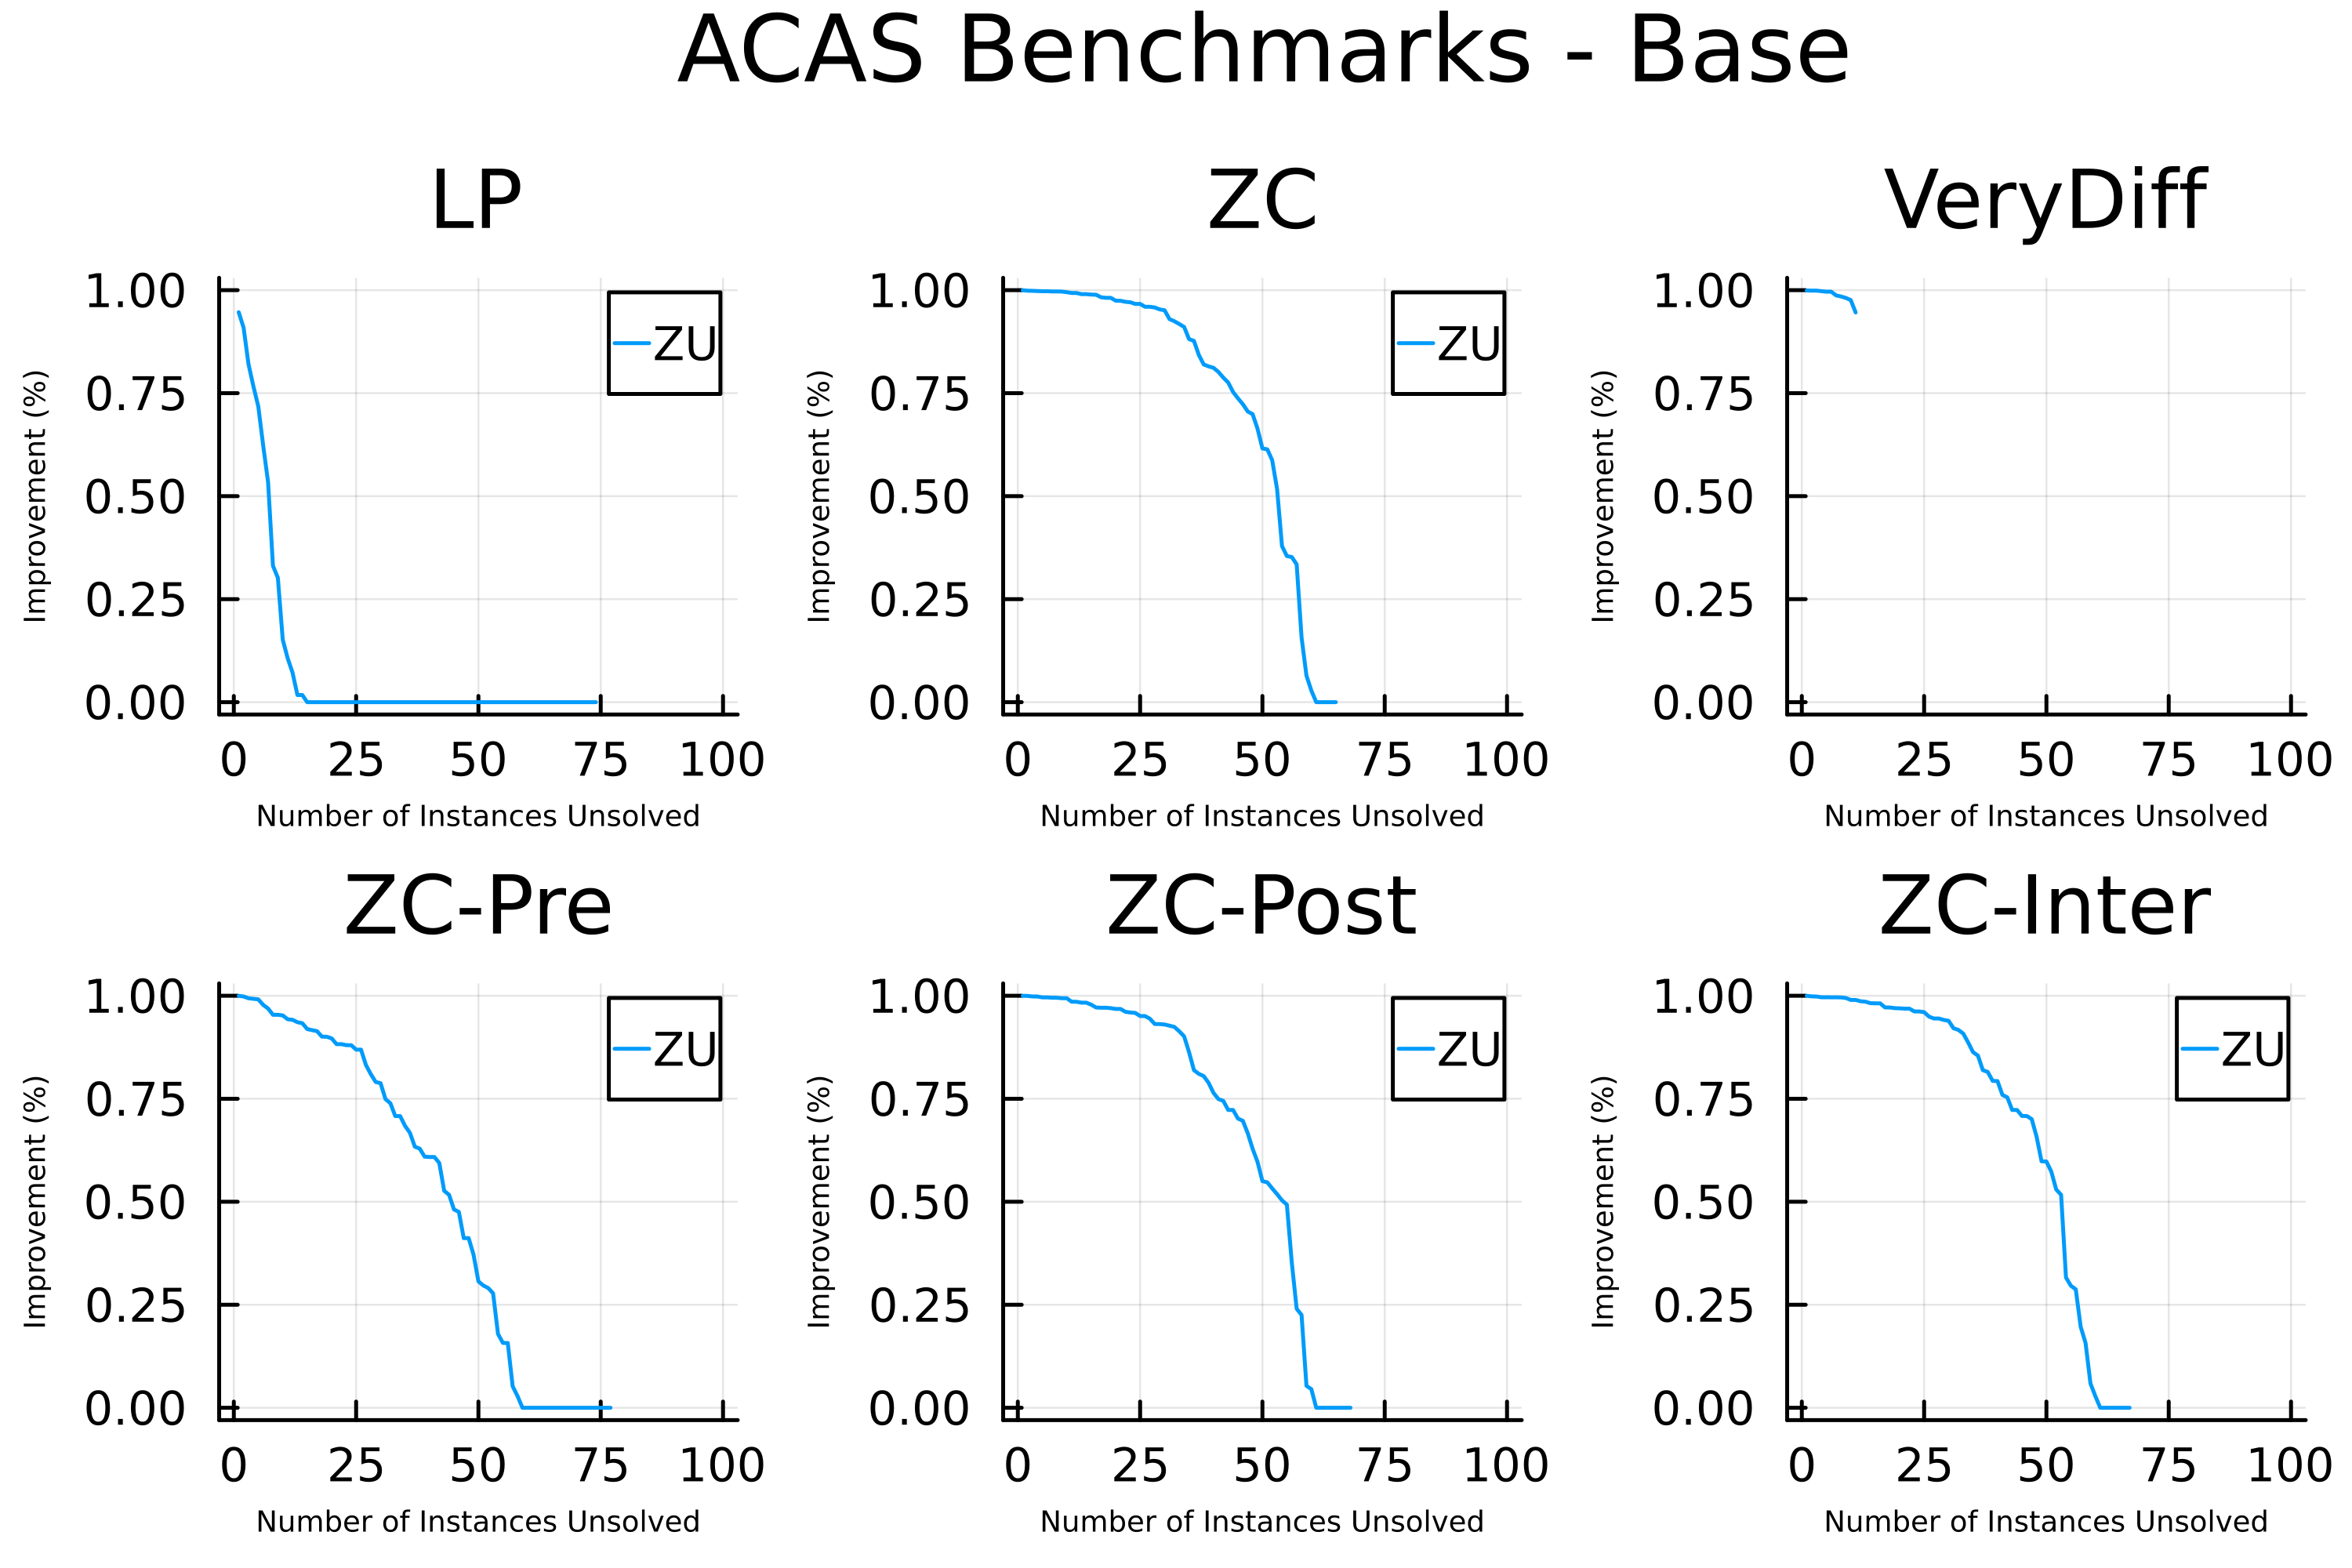

In [22]:
num_configs = size(base_configs, 1) + 1

p = plot(dpi=500, xlims=(0, 100), ylims=(0, 1), widen=true, xguidefontsize=5, yguidefontsize=5; layout=num_configs)
xlabel!("Number of Instances Unsolved")
ylabel!("Improvement (%)")

name, rgxs = verydiff_config
indices = filter_indices(acas_unsolved, rgxs)
plot!(p, x_acas_unsolved[indices], y_acas_unsolved[indices], title=name, label=nothing, subplot=3)

for (i, (name, rgxs)) in enumerate(base_configs)
    indices = filter_indices(acas_unsolved, rgxs)
    plot!(p, x_acas_unsolved[indices], y_acas_unsolved[indices], title=replace(name, "-Base" => ""), label=["ZU" "DU"], subplot=(i + i ÷ 3))
end

plot!(p, plot_title="ACAS Benchmarks - Base", plot_titlevspan=0.1)

savefig(p, "acas_benchmarks_unsolved_base.png")

p

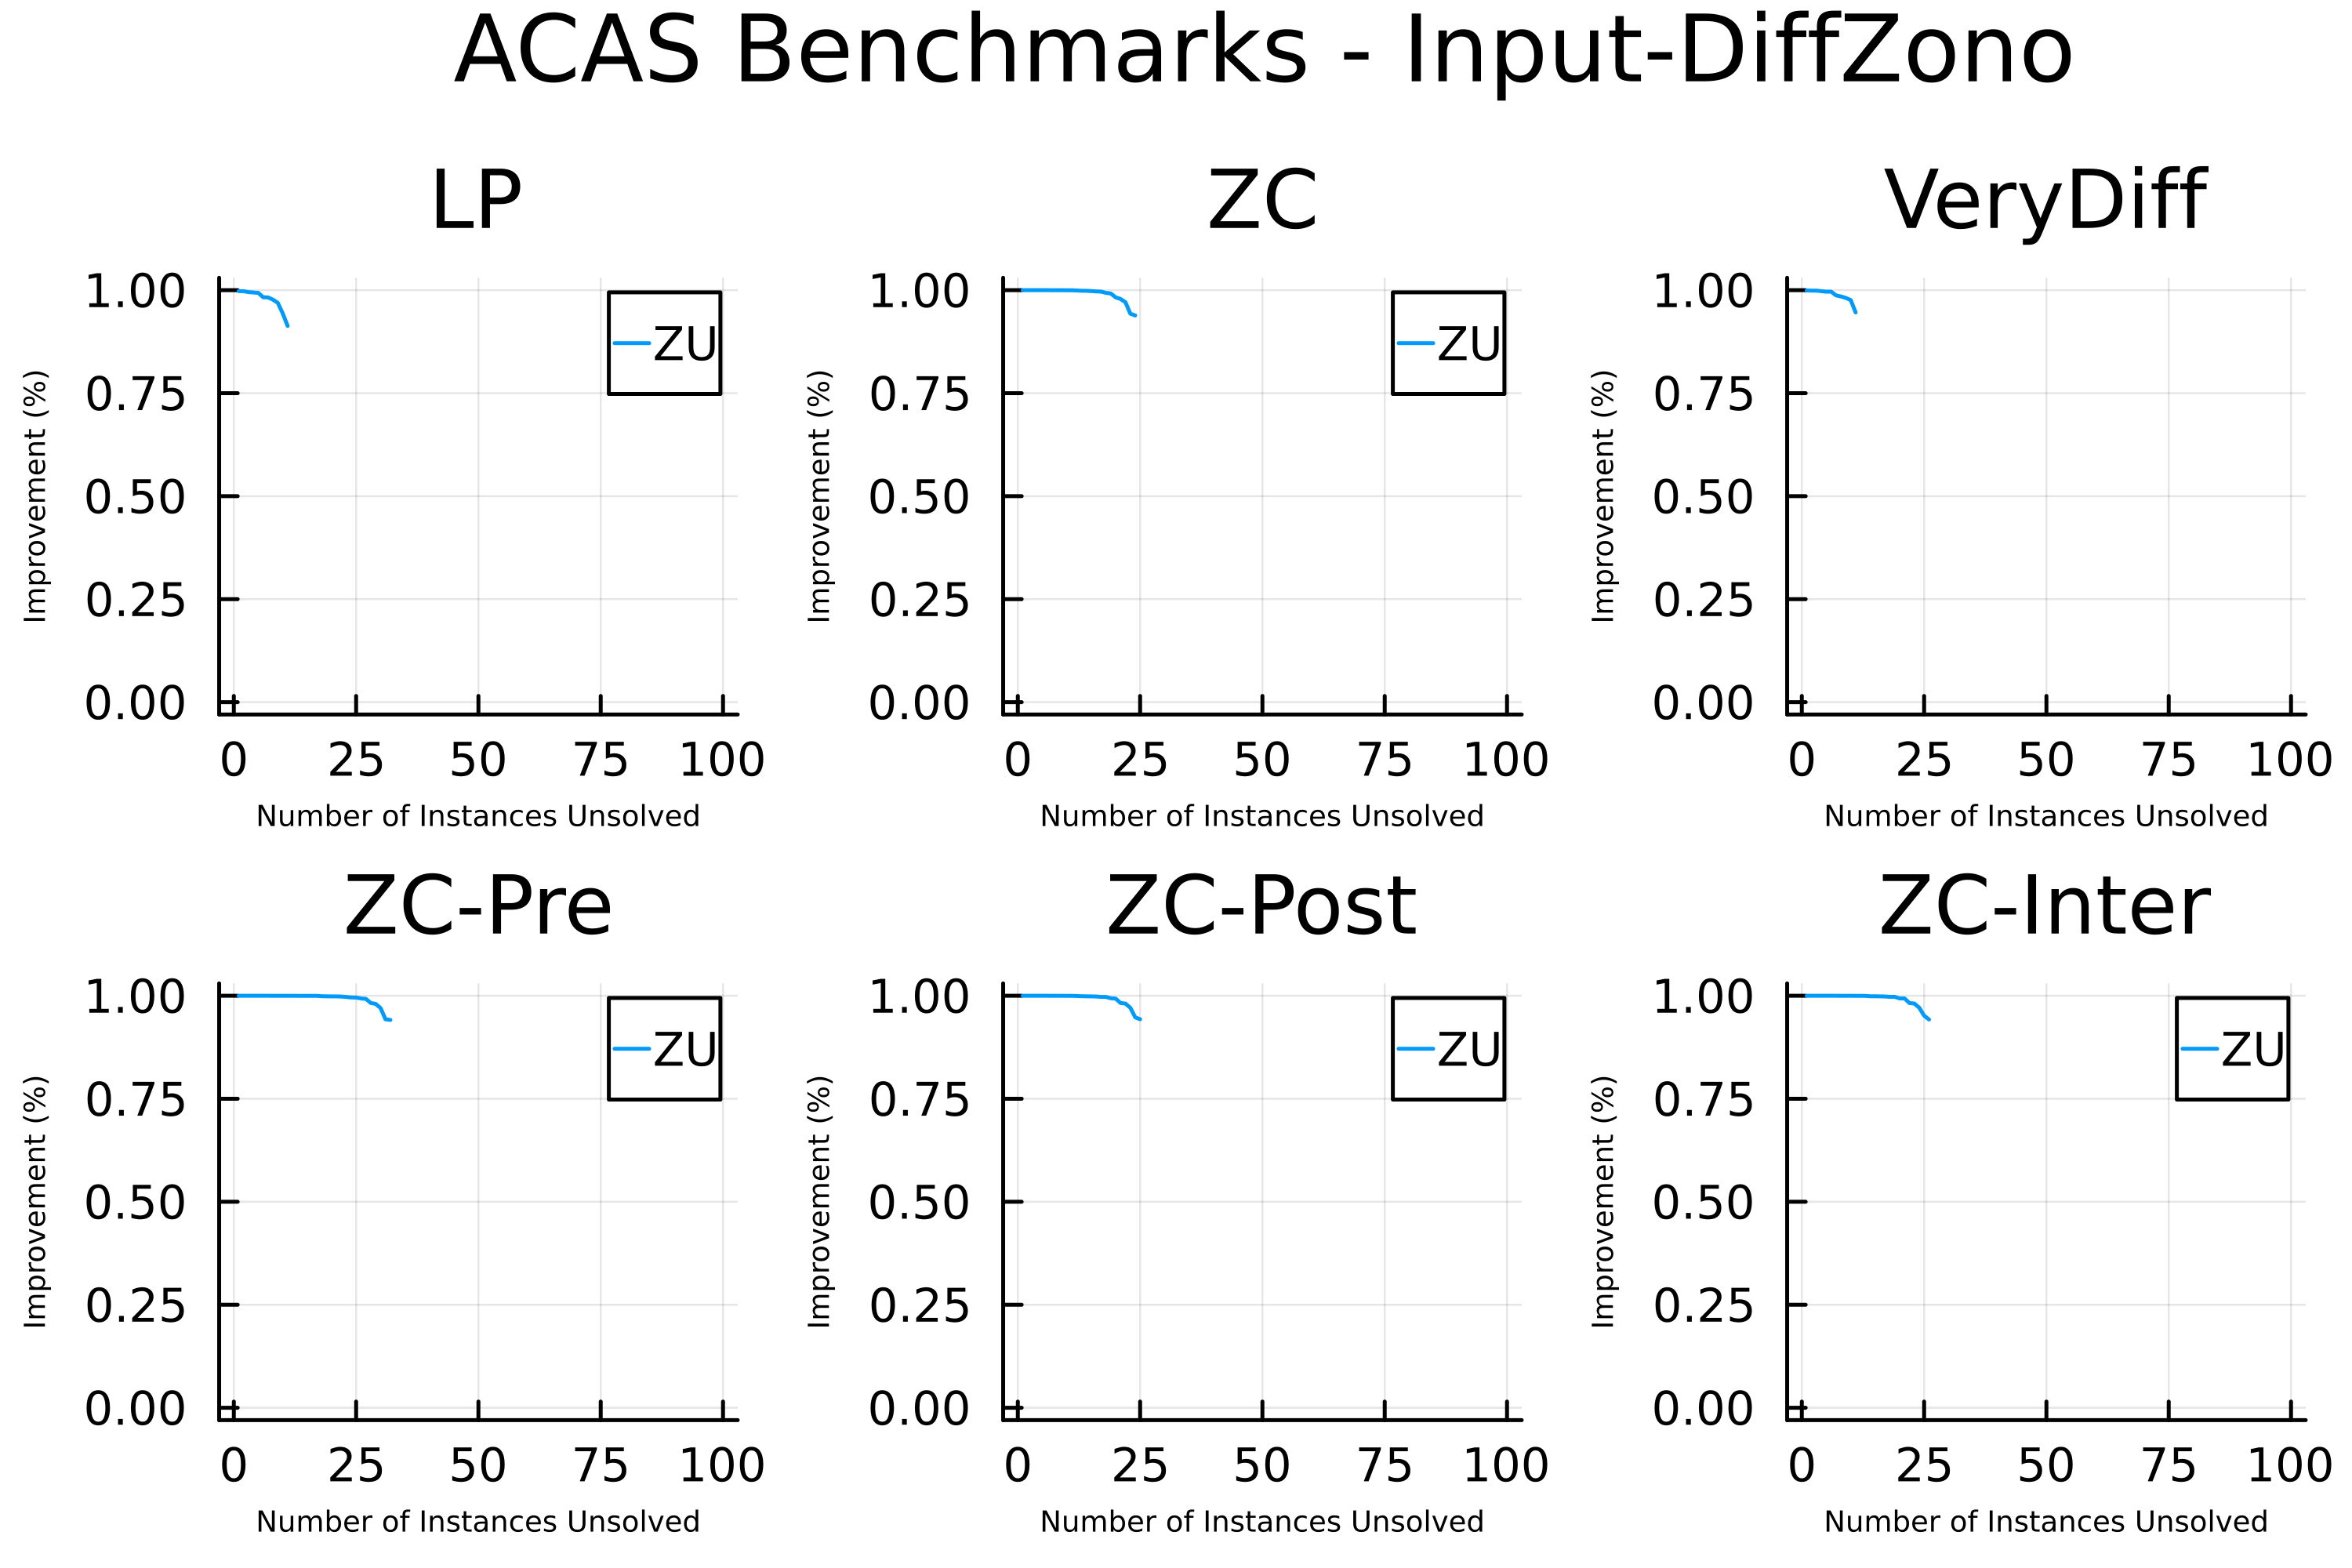

In [23]:
num_configs = size(input_diffzono_configs, 1) + 1

p = plot(dpi=500, xlims=(0, 100), ylims=(0, 1), widen=true, xguidefontsize=5, yguidefontsize=5; layout=num_configs)
xlabel!("Number of Instances Unsolved")
ylabel!("Improvement (%)")

name, rgxs = verydiff_config
indices = filter_indices(acas_unsolved, rgxs)
plot!(p, x_acas_unsolved[indices], y_acas_unsolved[indices], title=name, label=nothing, subplot=3)

for (i, (name, rgxs)) in enumerate(input_diffzono_configs)
    indices = filter_indices(acas_unsolved, rgxs)
    plot!(p, x_acas_unsolved[indices], y_acas_unsolved[indices], title=replace(name, "-Input-DiffZono" => ""), label=["ZU" "DU"], subplot=(i + i ÷ 3))
end

plot!(p, plot_title="ACAS Benchmarks - Input-DiffZono", plot_titlevspan=0.1)

savefig(p, "acas_benchmarks_unsolved_input_diffzono.png")

p